# Nonlinear Elasticity in a multipatch domain


In [1]:
# Here both, constant load over x-axis(length) and user-defined load possible!

In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

from geo_annulus import *
#from multipatch_block_handler import *
from plots import *
from ass_nonlin_el import *
from solver import *
from line_search import *


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
 no MKL


In [2]:
# 3 D #
p = 3 # spline degree
multi= 1
n_el = (12, 3, 6)  # number of elements in x, y, z direction, isotropic material
#n_el = (40, 8, 40)  # number of elements in x, y, z direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)


In [3]:
Mu= 27.9 * 1e-3 # N/mm²

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

def plot_geo(geo, grid=10, gridx=None, gridy=None, gridz= None,
             res=30,
             linewidth=None, color='black',  **kwargs):
    """Plot a wireframe representation of a 2D geometry."""
    #fig = plt.figure()
    
    if geo.sdim == 1 and geo.dim == 2:
        print("plot_curve")
        return plot_curve(geo, res=res, linewidth=linewidth, color=color)
    
    #print("geo.sdim:", geo.sdim)
    #print("geo.dim:", geo.dim)
    
    if geo.dim == geo.sdim == 2:
        #assert geo.dim == geo.sdim == 2, 'Can only plot 2D geometries'
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        supp = geo.support

        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotline(pts, capstyle='butt'):
            plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=linewidth,
                     solid_joinstyle='round', solid_capstyle=capstyle)

        pts = grid_eval(geo, (gridx, meshy))
        plotline(pts[0, :, :], capstyle='round')
        for i in range(1, pts.shape[0] - 1):
            plotline(pts[i, :, :])
        plotline(pts[-1, :, :], capstyle='round')

        pts = grid_eval(geo, (meshx, gridy))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

    
    if geo.sdim == geo.dim == 3:
        #print("3D geometry")
        # syntax for 3-D projection
        #ax = plt.axes(projection ='3d')
        #assert geo.dim == geo.sdim == 3, 'Can only plot 3D geometries'
        
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
            #print(gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        #print(meshx)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotline(pts, capstyle='butt'):
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap=cm.coolwarm, linewidth=linewidth,  **kwargs)

        pts = grid_eval(geo, (gridx, meshy, meshz))# meshy
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :]) # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end

        pts = grid_eval(geo, (meshx, gridy, meshz))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        pts = grid_eval(geo, (meshx, meshy, gridz))
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')

        # plotting
        #ax.set_title('3D line plot')
        #plt.show()


In [5]:
# define geometry
r_in = 1.93 #mm
r_out = 2.25 #mm

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]


# 3D
#geos_3d = [geometry.tensor_product(geometry.line_segment(0,1), g) for g in geos]
geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,5)) for g in geos]

In [6]:
class multipatch_block_handler:

    # Takes array of multi-patch objects
    def __init__(self, multi_patches):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X, multi_patch.patch_to_global(p)))
        return X

    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                # print(item[3])
                if len(item) < 4 or p in item[3]:
                    data_p.append((item[0], item[1], lambda *x: item[2](*x)[p]))
            if len(data_p) > 0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                # print('bcs_p', bcs_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    # Indices need offset
                    bcs[0] = np.concatenate((bcs[0], bcs_p[0] + offset))
                    # Values are kept as-is
                    bcs[1] = np.concatenate((bcs[1], bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)

    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset

##########################################


In [7]:
## 3D functions
#####################################################

def get_components3d(u, kvs_u):
    """Split solution vector into displacement components."""
    # print("shape_u", shape(u))
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    assert u.shape[0] == 3 * N
    m_u = tuple(kv.numdofs for kv in kvs_u)
    u1 = u[:N].reshape(m_u)
    u2 = u[N:2 * N].reshape(m_u)
    u3 = u[2 * N:3 * N].reshape(m_u)
    U = np.stack((u1, u2, u3), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


###############################################
# Energy functional
# Energy functional

# Energy functional
def energy3d(u_p, kvs_ux, geo_ux, X):
    Lam = 1624.94 * 1e-3  # N/mm²
    dis = get_components3d(X.T @ u_p, kvs_ux)
    e_term = '(.5*( grad(dis).T + grad(dis) + (grad(dis).T).dot(grad(dis)) ))'
    return sum(assemble.assemble(f'( Lam/2*tr({e_term})*tr({e_term}) + Mu*tr({e_term}.dot({e_term})) ) * aux * dx',
                                 kvs_ux, bfuns=[('aux', 1)], geo=geo_ux, dis=dis, Lam=Lam, Mu=Mu,
                                 idmat=np.identity(3)).ravel())


# Nonlinear variational form
def nonlinear_form3d(u_p, kvs_ux, geo_ux, X):
    Lam = 1624.94 * 1e-3   # N/mm²
    dis = get_components3d(X.T @ u_p, kvs_ux)
    e_term = '(.5*( grad(dis).T + grad(dis) + (grad(dis).T).dot(grad(dis)) ))'
    f_term = '( idmat + grad(dis) )'
    return assemble.assemble(f'inner( ({f_term}).dot( Lam*tr({e_term})*idmat + 2*Mu* {e_term} ), grad(v) ) * dx',
                             kvs_ux, bfuns=[('v', 3)], geo=geo_ux, dis=dis, Lam=Lam, Mu=Mu,
                             idmat=np.identity(3)).ravel()


# Linearized variational form
def linearized_form3d(u_p, kvs_ux, geo_ux, X):
    Lam = 1624.94 * 1e-3    # N/mm²
    dis = get_components3d(X.T @ u_p, kvs_ux)
    e_term = '(.5*( grad(dis).T + grad(dis) + (grad(dis).T).dot(grad(dis)) ))'
    e_deriv = '(.5*( grad(u).T + grad(u) + grad(u).T.dot(grad(dis)) + grad(dis).T.dot(grad(u)) ))'
    f_term = '( idmat + grad(dis) )'
    f_deriv = 'grad(u)'
    return assemble.assemble(
        f'inner( ({f_deriv}).dot( Lam * tr({e_term}) * idmat + 2*Mu*{e_term} )+ ({f_term}).dot( Lam * tr({e_deriv}) * idmat + 2*Mu*{e_deriv}), grad(v) ) * dx',
        kvs_ux, bfuns=[('u', 3), ('v', 3)], geo=geo_ux, dis=dis, Lam=Lam, Mu=Mu, idmat=np.identity(3))


### mass matrix ###
def ass_mass3d(MP_block):
    first = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy

        M_x = assemble.mass(kvs_ux, geo_ux)
        M_p = scipy.sparse.bmat(
            [[M_x, None, None],
             [None, M_x, None],
             [None, None, M_x]], format='csr')

        if first:
            M = X @ M_p @ X.T
            first = False
        else:
            M += X @ M_p @ X.T

    return M

########################################
# assemble linear system and right-hand side (with Neumann)
def ass_nonlinsystem3d(u, MP_block, neu_data):
    first = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy

        # The whole patch-local stiffness matrix
        A_p = linearized_form3d(u, kvs_ux, geo_ux, X)  # take linearized variatonal form

        # The patch-local Neumann boundary data, right-hand side
        b_p = -nonlinear_form3d(u, kvs_ux, geo_ux, X)

        # Neumann data
        N_e, bdofs = ass_Neumann3d(p, MP_block, neu_data)
        for c in range(3):  # x and y
            offset = MP_block.compute_local_offset_for_component(p, c)
            for i in range(len(bdofs)):
                b_p[bdofs[i] + offset] += N_e[c, i]  # (43,1,2)

        if first:
            A = X @ A_p @ X.T
            b = X @ b_p
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p
            
    return A, b


##############################################################
# assemble linear system and right-hand side (with Neumann)
def ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR):
    A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
    return A + AR, b - AR @ u

##################################################
### assemble Neumann bdc ####

def ass_Neumann3d(p, MP_block, neu_data):
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy
    for item in neu_data:
        if item[0] == p:
           # with function gN
            N_e = assemble.assemble('inner(g,v)*ds', kvs_ux, geo=geo_ux, g=item[2], bfuns=[('v', 3)],symmetric=True, boundary=item[1]).ravel()
            #N_e = -item[3] * assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, g=item[2], boundary=item[1]).ravel()
            N_e = N_e.reshape(3, -1)  # 3dim, -1 remaining factor to get to the total number of elements
            bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
    return N_e, bdofs


### assemble Robin bdc ####

def ass_Robin3d(MP_block, robin_data):
    firstR = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        for item in robin_data:
            if item[0] == p:
                AR_u = item[3] * assemble.assemble('u * v *g*ds', kvs_ux, bfuns=[('u', 1), ('v', 1)], geo=geo_ux,
                                                   g=item[2],  # Here only scalar!
                                                   format='csr', layout='blocked', boundary=item[1])
                bdofs_R = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(3):  # x and y
                    offset = MP_block.compute_local_offset_for_component(p, c)
                    if firstR:
                        AR = X.tocsr()[:, bdofs_R + offset] @ AR_u @ X.tocsr()[:, bdofs_R + offset].T
                        firstR = False
                    else:
                        AR += X.tocsr()[:, bdofs_R + offset] @ AR_u @ X.tocsr()[:, bdofs_R + offset].T
    return AR

#######################
#### rhs + Neumann BC 
def ass_rhs3d(u, MP_block, neu_data):
    first = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy

        b_p = -nonlinear_form3d(u, kvs_ux, geo_ux, X)

        N_e, bdofs = ass_Neumann3d(p, MP_block, neu_data)
        for c in range(2):  # x and y
            offset = MP_block.compute_local_offset_for_component(p, c)
            for i in range(len(bdofs)):
                b_p[bdofs[i] + offset] += N_e[c, i]  # (43,1,2)

        if first:
            b = X @ b_p
            first = False
        else:
            b += X @ b_p
            
    return b

#########################################

# for Robin bdc only
##################################
#### rhs + Neumann BC + Robin BC ####
def ass_rhs_RN3d(u, MP_block, neu_data, AR):
    b = ass_rhs3d(u, MP_block, neu_data)
    return b - AR @ u

################################################
# derive energy functional (with Neumann + Robin)
def ass_energy3d(u, MP_block, kvs_j, neu_data=None, robin_data=None):
    j = 0
    for p in range(MP_block.numpatches):  # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        j_p = energy3d(u, kvs_ux, geo_ux, X)
        dis = get_components3d(X.T @ u, kvs_ux)

        j_R = 0  ###!!
        j_N = 0  ###!!

        # Robin-Data
        if robin_data != None:
            for item in robin_data:
                if item[0] == p:
                    # Rg =assemble.assemble('inner(g,aux)*ds', kvs_j, bfuns=[('aux',2)], geo=geo_ux, g=item[2], boundary=item[1])
                    # print(Rg.sum())
                    R_p = item[3] / 2 * assemble.assemble('inner(dis,dis) *g* aux * ds', kvs_j, bfuns=[('aux', 1)],
                                                          dis=dis, geo=geo_ux, g=item[2], boundary=item[1],
                                                          layout='packed')  # first attempt
                    j_R += R_p.sum()
        if neu_data != None:
            for item in neu_data:
                if item[0] == p:
                    #N_e = -item[3]*assemble.assemble('inner(n, dis) * aux * ds', kvs_j, bfuns=[('aux',1)], geo=geo_ux, boundary=item[1], dis=dis)
                    N_e = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v', 1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis)
                    # print('N_e=', N_e)
                    j_N += N_e.sum()

        j += (j_p + j_R - j_N)

    return j

####################################

In [8]:
patches_u = [(kvs_u, g) for g in geos_3d] # 3D

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True) #3D

In [9]:
# define boundary conditions

In [10]:
# source term f, 3D
def f(x, y, z): return (0.0, 0.0, 0.0)

In [11]:
# not needed! --> use implemented normal vector in assembling routine!
#Neumann BC #
def gN0(x, y, z): 
#quarter annulus in y/z coord.system
    return (0, y/r_in*l_val, z/r_in*l_val) # inner pressure, in normal direction (0, 1, 1)

# quarter annulus in x/y coord.system
   # return (x/r_out*loading_value, y/r_out*loading_value, 0)  #inner  pressure, normalized vector

In [12]:
def g0(x,y,z): #different load over x-axis
    if (x > 1.5).all() and (x < 3.5).all(): # set force at middle only
    #if(x>0).all(): # set force equally over x-axis
        return l_val 
    else:
        return 0

In [13]:
def gN(x, y, z): #different load over x-axis
    #if isinstance(x,numpy.float64):
        #print(x)
    s_y = shape(y)
    fac = [g0(xi,y, z) for xi in np.nditer(x)]
    fac= np.reshape(fac, s_y)
    return (0, y/r_in* fac,z/r_in*fac)# inner pressure

In [14]:
# Multipatch objects for all variables (x, y, z)
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_u] ) 

In [15]:
# define Dirichlet boundary function 
def g_zero(x, y, z): return (0.0, 0.0, 0.0) # fixed in y/z, x runs, evtl. set x=x

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'top', g_zero ) # outer bd, 1
])

In [16]:
# Compute solution of nonlinear elasticity problem

In [17]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [18]:
M = ass_mass3d(MP_block)
Minv = make_solver(M)

use SuperLU


In [19]:
#incremental loading
maxload = 5.666e-3 #2.666e-3 #1.5e-3 #13.33*1e-3 #1.5e-2 #2e-3
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [20]:
# No Robin-bdc
robin_data = None

In [21]:
def J(u):
    return ass_energy3d(u, MP_block, kvs_j, neu_data)


def grad_J(u):
    return -ass_rhs3d(u, MP_block, neu_data)


In [22]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN, l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann

    
### first iteration ###
A, b = ass_nonlinsystem3d(u, MP_block, neu_data) # without Robin-matrix

LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0 = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

u_d = make_solver(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d

# new solution
A, b = ass_nonlinsystem3d(u, MP_block, neu_data) # without Robin-matrix
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
print('Residual  =', r)
print('Energy    =', J(u))

###-----------------###--------------------###
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
#get_defplot3d(u, patches_u, kvs_u, MP_u, n_el)

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod1fc87c449dfb89ce.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod1fc87c449dfb89ce.pyx


Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modaac69c2e5766f73b.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modaac69c2e5766f73b.pyx
Residual0 = 0.07012164283097282
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod9cd0210e836640c2.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod9cd0210e836640c2.pyx
Energy0   = 0.0
use SuperLU
Residual  = 2924.6274490240594
Energy    = 1.0775211763110497


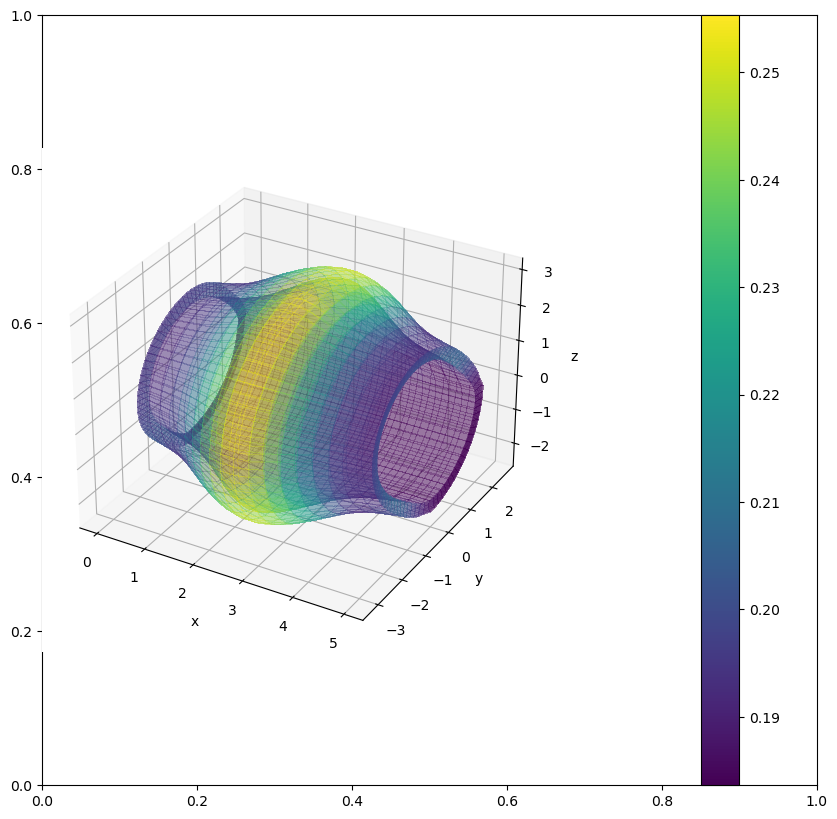

In [24]:
get_defplotC(u, patches_u, kvs_u, MP_u)

In [25]:
#get_defplotpp3d(u, patches_u, kvs_u, MP_u)

In [23]:
# loading, solve exactly in last laoding step
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]
u= np.zeros(dd)

max_err= 1e-11# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN, l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann


    count = 0
    while count <len(loading)-2:
        A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
        
        count+=1
        print(count)
         # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(LS.A).dot(LS.b)
        u_d = LS.complete(u_d)
        u += u_d   
        
        w= np.inner(np.transpose(u_d),rhs)
        err = np.sqrt(np.abs(w))
        print('Error=', err)

        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
    iter_counts.append(count)
    count=0

while True:
    A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    rhs= LS.complete(LS.b)
    r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
    print('Residual =',r)
    print('Energy   =',J(u))
    
    # # solve system # #
    #u_d = make_solver(A).dot(b) 
    u_d = make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d)
    
    w= np.inner(np.transpose(u_d),rhs)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 30:
        break
    
    count+=1
    print(count)
    # update solution
    u += u_d   
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #iter_counts.append(count)
    #---------------------------------------------------#

ud_array.append(u_d) 
print('u= ' , u)
solutions.append(LS.restrict(u))
iter_counts.append(count)
    
sum(iter_counts)
        
# print deformation plot
# get_defplotC(u, patches_u, kvs_u, MP_u)
#print("done")

 
 
 1. loading: 0.0018886666666666667 

Residual = 0.00779129364788587
Energy   = 0.0
1
use SuperLU
Error= 0.09191081218775231
 
 
 2. loading: 0.003777333333333333 

Residual = 31.43464469640501
Energy   = 0.002814872318481176
1
use SuperLU
Error= 0.1654399033849535
 
 
 3. loading: 0.005666 

Residual = 0.21887364608562132
Energy   = -0.020266755781755963
1
use SuperLU
Error= 0.10924212603793952
Residual = 12.349128854588379
Energy   = -0.01827696074322107
use SuperLU
Error= 0.11221258606841862
1
Residual = 0.017680434159874015
Energy   = -0.024818748257324764
use SuperLU
Error= 0.02120328179342128
2
Residual = 0.24295849864166882
Energy   = -0.024862709106259387
use SuperLU
Error= 0.014416540815230666
3
Residual = 0.0001323087934365505
Energy   = -0.024960530210690605
use SuperLU
Error= 0.002815297357609168
4
Residual = 0.0020385603748524343
Energy   = -0.024946930574996994
use SuperLU
Error= 0.0012786926592413966
5
Residual = 5.3799033537255414e-08
Energy   = -0.0249475341610255
u

11

In [27]:
def get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, **kwargs):
    vrange= None
    # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx) # e.g. linespace(0, 1, 10)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1],**kwargs)

        xgridyz = (gridx,gridx, gridx)
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
    
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
    
        #C = np.sqrt( np.power(dis[..., 0], 2)+np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])

        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
    
    vrange = (C.min(), C.max())
    #vrange = (0, 1.5e-5)
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)


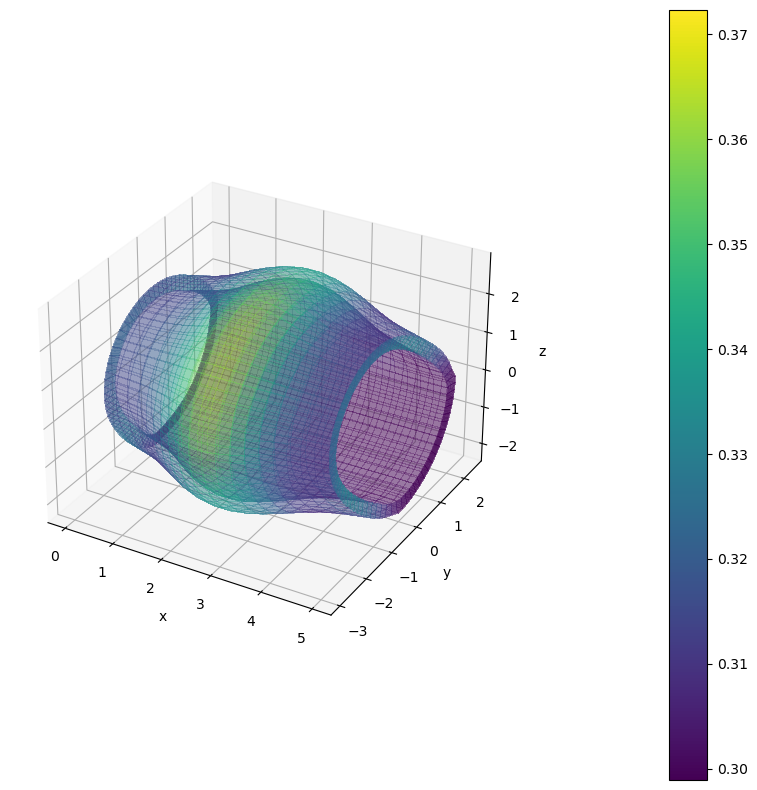

In [28]:
figsize(10,10)
fig = plt.figure()
ax = plt.axes(projection ='3d')
u1_funcs, u2_funcs, u3_funcs= split_u3d(u, MP_u, kvs_u, patches_u)
get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.savefig('dir3d_3.png')
plt.show()

In [29]:
sum(iter_counts)

11


 patch: 0
displacement_inner= [[-4.68375339e-17  1.14435486e-01  1.15545317e-01]]
displacement_outer= [[0. 0. 0.]]
(20, 20, 1)
inner_radius:  2.0476980187290965
inner_radius:  2.0476980187290965
dis_inner_y/dis_outer_y:  inf
dis_inner_z/dis_outer_z:  inf

 patch: 1
displacement_inner= [[-2.08166817e-17 -1.15545317e-01 -1.14435486e-01]]
displacement_outer= [[0. 0. 0.]]
(20, 20, 1)
inner_radius:  2.0476980187290965
inner_radius:  2.0476980187290965
dis_inner_y/dis_outer_y:  -inf
dis_inner_z/dis_outer_z:  -inf

 patch: 2
displacement_inner= [[ 0.         -0.77212924  0.15685453]]
displacement_outer= [[ 5.72458747e-17 -7.00693688e-01  1.44948778e-01]]
(20, 20, 1)
inner_radius:  2.7066779920444555
inner_radius:  2.7066779920444555
dis_inner_y/dis_outer_y:  1.1019497523891912
dis_inner_z/dis_outer_z:  1.0821376237957976

 patch: 3
displacement_inner= [[-1.66533454e-16 -1.56854526e-01  7.72129236e-01]]
displacement_outer= [[ 4.51028104e-17 -1.44948778e-01  7.00693688e-01]]
(20, 20, 1)
inner_

/home/hilbert/heigl/anaconda/pyiga/notebooks/plots.py:865: RuntimeWarning: divide by zero encountered in double_scalars
  print( 'dis_inner_y/dis_outer_y: ', dis2[0,0,0]/dis2[0,res-1,0])
/home/hilbert/heigl/anaconda/pyiga/notebooks/plots.py:866: RuntimeWarning: divide by zero encountered in double_scalars
  print( 'dis_inner_z/dis_outer_z: ', dis3[0,0,0]/dis3[0,res-1,0])


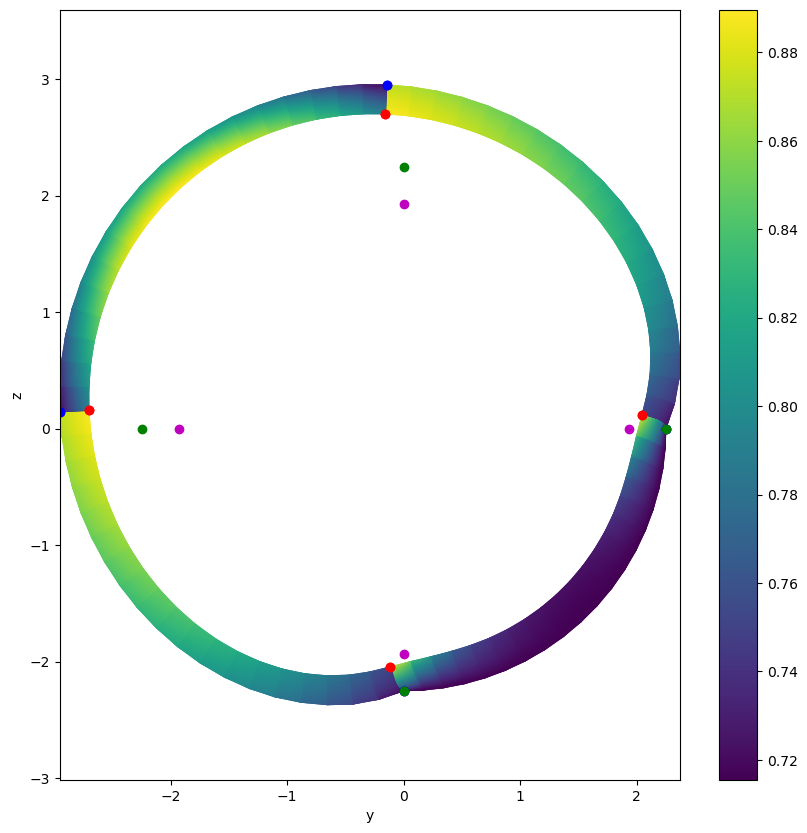

In [30]:
get_defplotpp3d(u, patches_u, kvs_u, MP_u, n_el)

In [31]:
vol_ratio= global_vol3d(u, MP_block, kvs_j)

In [32]:
cs = cauchystress3d(u, MP_block)
print(max(cs))

Compiling /home/hilbert/heigl/.cache/pyiga/modules/mode1631ff923c895e7.pyx because it changed.
[1/1] Cythonizing /home/hilbert/heigl/.cache/pyiga/modules/mode1631ff923c895e7.pyx


In file included from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/hilbert/heigl/.cache/pyiga/modules/mode1631ff923c895e7.c:776:
/home/hilbert/heigl/anaconda/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


0.8157203008038703


In [28]:
l_vol= local_vol3d(u, MP_block)

use SuperLU


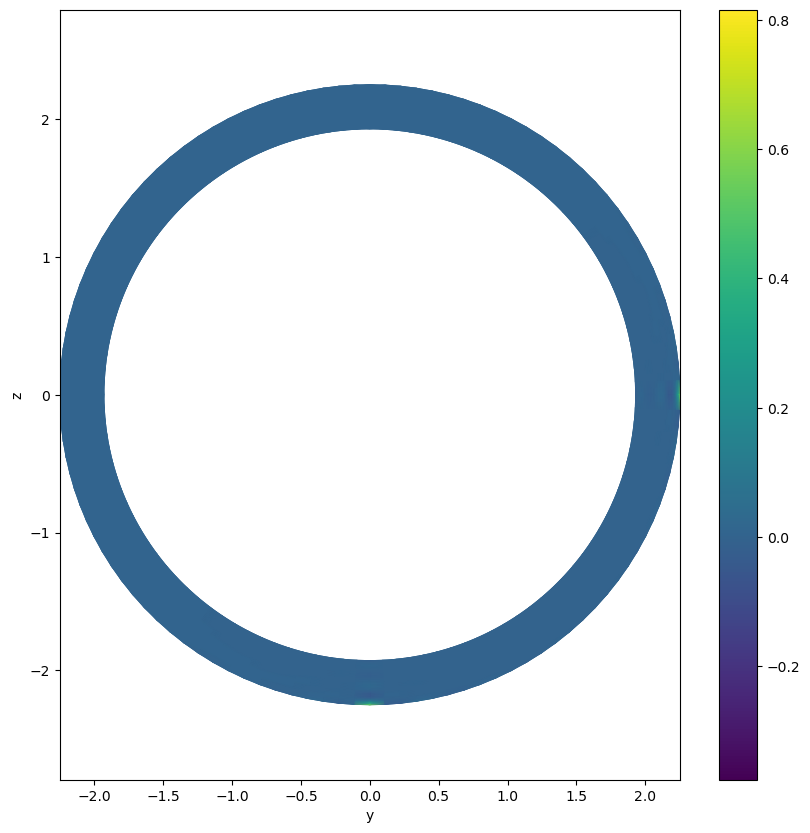

In [34]:
get_defplot_scalar3d(cauchystress3d(u, MP_block), patches_u, kvs_u, MP_u, n_el, geos, cs)

In [29]:
# for scalar-valued input vector
def get_defplot_scalar3d(val,u, patches_u, kvs_u, MP_u, n_el, geos, arr, res=30):
    val_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ val)
               for p in range(len(patches_u))]

    u1_funcs, u2_funcs, u3_funcs = split_u3d(u, MP_u, kvs_u, patches_u)   
    
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    z_el = n_el[2]
    
    vrange= None
    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (val_func,u1_func, u2_func, u3_func, (kvs, geo)) in zip(val_funcs, u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        gridz= 1
        supp = geo.support
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][1]/2, supp[2][1]/2, 1) # evaluate in the middle 

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #vrange = (C.min(), C.max())
            #vrange = (-2.5e-4, 5.5e-4)
            vrange = (arr.min(), arr.max())
            #vrange = (2e-4, 5.5e-4)

            plt.pcolormesh(pts[..., 1], pts[..., 2], C, shading='gouraud', cmap='viridis', vmin=vrange[0], vmax=vrange[1])


        zgridxy = (meshx, meshy, gridz)
        # z-grid
        vol = val_func.grid_eval(zgridxy) #x-value
        G= grid_eval(geo, zgridxy)
        C  = vol
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        #pts = grid_eval(geo, zgridxy) # z-coord ## undeformed
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1]) 

       #if vrange is None:
            #vrange = (C.min(), C.max())
        
        
    plt.colorbar();
    plt.axis('equal')
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    plt.show()
    plt.savefig('dir3d2_vol.png')
 
    

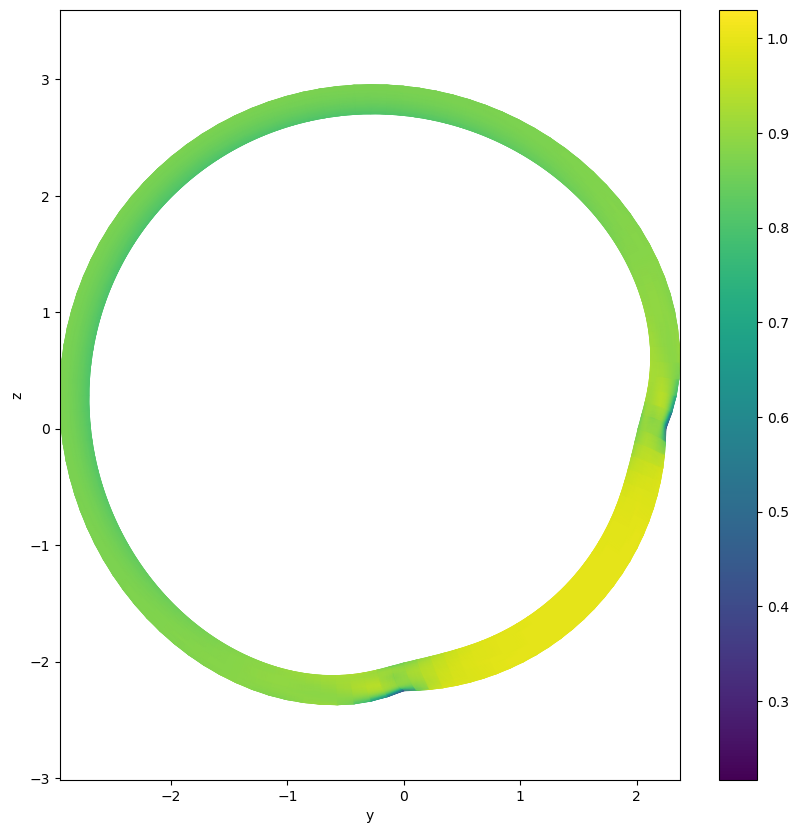

<Figure size 640x480 with 0 Axes>

In [31]:
get_defplot_scalar3d(l_vol, u, patches_u, kvs_u, MP_u, n_el, geos, l_vol)

In [36]:
sum(iter_counts)

11

In [37]:
s_sol= shape(solutions)[0]

In [38]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field_3d(fields, patches_u, kvs_u, vrange=None, res=50,cmap=None, interval=50, progress=False):
    """Animate a sequence of scalar fields over a geometry."""
    
    figsize(10,10)
    fig = plt.figure()
    ax = plt.axes(projection ='3d') #,xlim=(0, 2), ylim=(-0.5, 0.5)
    
    fields = list(fields)
    ar= np.linspace(1,20, s_sol)
    factor = ar[0]
    vrange = None
    
    # first solution
    u= LS.complete(fields[0])
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    def plotlineC(pts, C, capstyle='butt'):
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])

     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        
        gridx = np.linspace(supp[0][0], supp[0][1], 2) # e.g. linespace(0, 1, 2)
        gridy = np.linspace(supp[1][0], supp[1][1], 2)
        gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
        
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
        
      
        #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])

        
        ##'''
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
    vrange = (C.min(), C.max())
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])   
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    #plt.show()
  
    #fig.colorbar(quadmesh, ax=ax);
    #colorbar();
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    def anim_func(i):
        plt.cla()
        
        vrange= None
        factor = ar[i] # choose factor for deformation plot
        #u= fields[i]
        u = LS.complete(fields[i])

        #Split solution vector into displacement components
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:2*MP_u.numdofs]
        u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

        # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]
        u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
               for p in range(len(patches_u))]
        
             # visualization per patch
        
        for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

            # y-grid 
            dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(ygridxz) #y-value
            dis3 = u3_func.grid_eval(ygridxz) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
            print('max_val:', amax(dis))
            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

            pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
            #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, 0, :], C[:, 0, :])
            for j in range(1, pts.shape[1] - 1):
                plotlineC(pts[:, j, :], C[:, j, :])
            plotlineC(pts[:, -1, :], C[:, -1, :])

            # z-grid
            dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(zgridxy) #y-value
            dis3 = u3_func.grid_eval(zgridxy) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            #vrange = (C.min(), C.max())
            #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])

            pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
            C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            print('max_valC:', amax(C))
            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, :, 0],C[:, :, 0])
            for k in range(1, pts.shape[2] - 1): 
                plotlineC(pts[:, :, k], C[:, :, k])
            plotlineC(pts[:, :, -1], C[:, :, -1])
        
        pbar.update()
        if i == len(u) - 1:
            pbar.close()
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)

  0%|                                                                                                                                 | 0/1 [00:00<?, ?it/s]

max_val: 0.7664503535650887
max_valC: 0.46937834690441516
max_val: 0.11455880151497375
max_valC: 0.04028073888078616
max_val: 0.3373297448254182
max_valC: 0.46937834690441504
max_val: 0.7749224029388626


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]

max_valC: 0.37233164321987017
max_val: 0.7664503535650887
max_valC: 0.46937834690441516
max_val: 0.11455880151497375
max_valC: 0.04028073888078616
max_val: 0.3373297448254182
max_valC: 0.46937834690441504


2it [00:01,  1.02s/it]                                                                                                                                      

max_val: 0.7749224029388626
max_valC: 0.37233164321987017


2it [00:03,  1.83s/it]


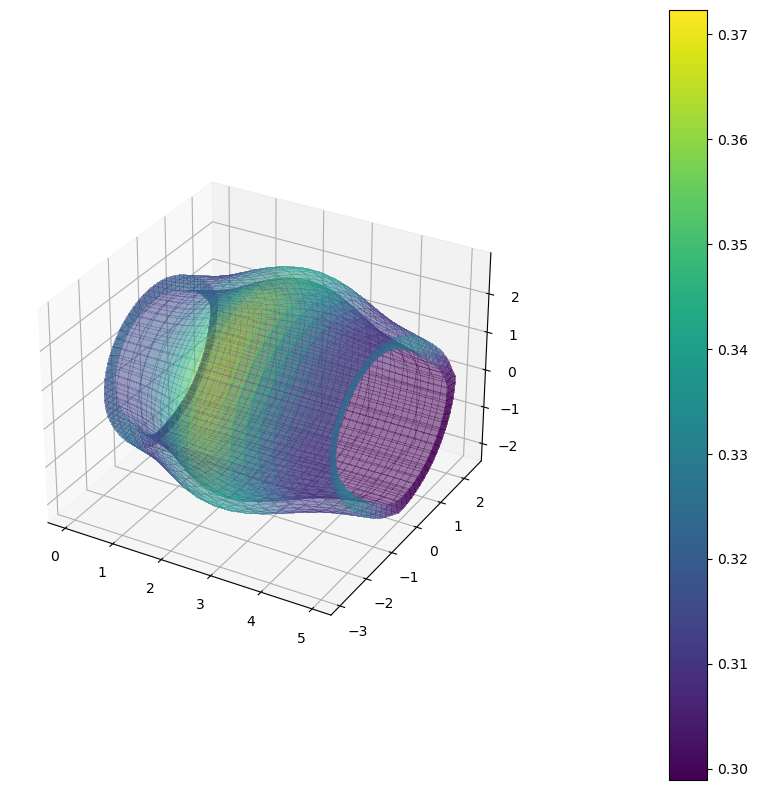

In [39]:
from IPython.display import HTML

figsize(14, 4)
#fields = [ud_array[tt] for tt in range(s_sol)]
fields = [solutions[tt] for tt in range(s_sol)] ## time steps
HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=535, progress=True).to_html5_video())
#writervideo = animation.FFMpegWriter(fps=15)
#HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=600, progress=True).save('Dir3d26_gc.mp4', writer=writervideo))

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['font.size'] = 18

figsize(10,10)
fig = plt.figure()
ax = plt.axes(projection ='3d') #,xlim=(0, 2), ylim=(-0.5, 0.5)
#fig, ax = plt.subplots(figsize=(8,8))
#ax.set_aspect('equal')
res=50
#vrange=(0.0, 1.5e-3)

s_sol= shape(solutions)[0]
ims = []
ar= np.linspace(1,2, s_sol)
factor = 1


#fields = list(ud_array)
fields = list(solutions)

for tt in range(s_sol):
    u = LS.complete(fields[tt])
    #u = fields[tt]
    factor = 1 #ar[tt] # choose factor for deformation plot#
    vrange = None
    ims_q = []
    
 #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
 
    plt.ioff()
    
    def plotlineC(pts, C, capstyle='butt'):
            #if vrange is None:
            vrange = (C.min(), C.max())
                #vrange = (0, 1.5e-5)
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            im_q = ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            im_q.set_array(C.ravel()) 
            ims_q.append(im_q)
    
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        
        gridx = np.linspace(supp[0][0], supp[0][1], 2) # e.g. linespace(0, 1, 2)
        gridy = np.linspace(supp[1][0], supp[1][1], 2)
        gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
        
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        im_q=[]
        
        
#         # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
        
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        #C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        print('max_valC:', amax(C))
        
#         if vrange is None:
#             vrange = (C.min(), C.max())
#         im_q = ax.plot_surface(pts[..., 0]+ factor*dis[..., 0], pts[..., 1]+ factor*dis[..., 1], pts[..., 2]+ factor*dis[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
#         im_q.set_array(C.ravel()) 
#         ims_q.append(im_q)
        
        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])

        
#         ##'''
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid  
        #print('max_val:', amax(dis))
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        print('max_valC:', amax(C))
        #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])

    
    ims.append(ims_q)

#fig.colorbar(im_q, ax=ax);
vrange = (C.min(), C.max())
norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])   
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    #plt.show()
#colorbar();
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat= False) # repeat_delay=2000



#ani.to_html5_video()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'))
ani.save("Dir_3d_26c.mp4", writer=writer )
vid = ani.to_html5_video()

plt.close()



max_valC: 0.787058564842891
max_valC: 0.46954702961870254
max_valC: 0.1623636687376445
max_valC: 0.04028074770958004
max_valC: 0.7870585648428913
max_valC: 0.4695470296187026
max_valC: 0.8890954515803616
max_valC: 0.37233164321987017


In [41]:
ani

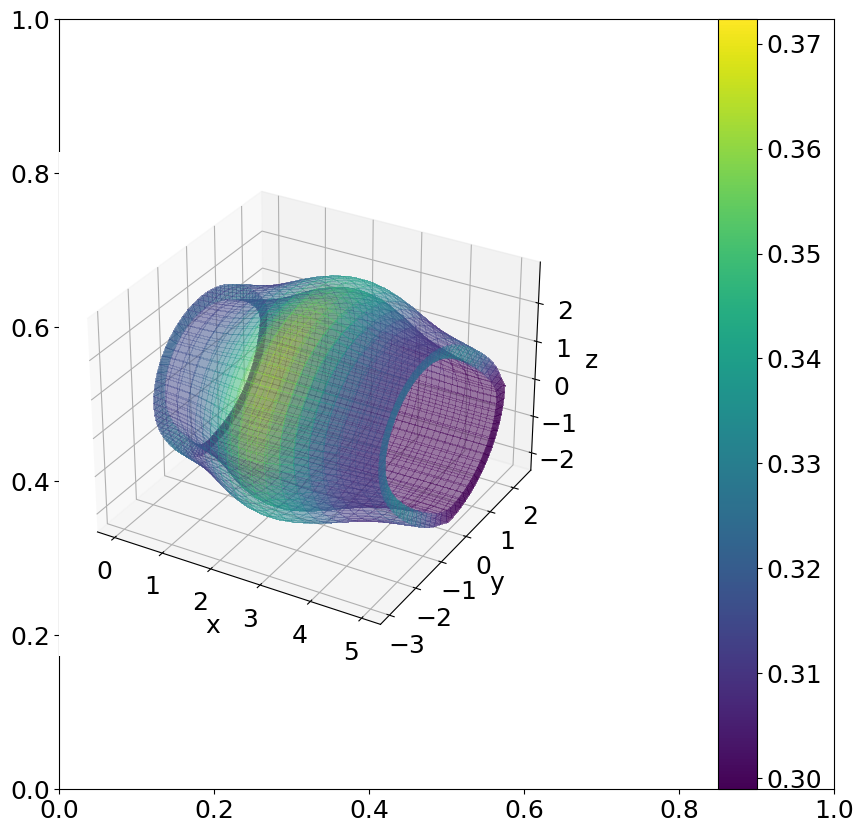

In [42]:
get_defplotC(u, patches_u, kvs_u, MP_u)

 
 
 max. loading: 0.005666 

Residual = 0.07012164283097283
Energy   = 0.0
Error= 0.27573243656272334
1
Residual = 2924.6274489832686
Energy   = 1.0775211762970114
Error= 1.4016573196385533
2
Residual = 64.62178393113535
Energy   = 0.006009578765011515
Error= 0.23364961931058956
3
Residual = 0.7018090563533077
Energy   = -0.022794225071281718
Error= 0.06535877431112937
4
Residual = 0.9761845156283597
Energy   = -0.024140879587730563
Error= 0.03602888281355018
5
Residual = 0.008445050762752615
Energy   = -0.02485808513783832
Error= 0.013407181453708244
6
Residual = 0.018007811163485998
Energy   = -0.024938674602276216
Error= 0.004452150728994076
7
Residual = 8.944159593075583e-06
Energy   = -0.024949099932262266
Error= 0.000517239301876175
8
Residual = 4.548976236040352e-06
Energy   = -0.024947032655892626
Error= 5.724178170867041e-05
9
Residual = 3.513218424182511e-12
Energy   = -0.024946994417633497
Error= 5.21195305500438e-07
10
Residual = 2.3438836566446867e-17
Energy   = -0.024946

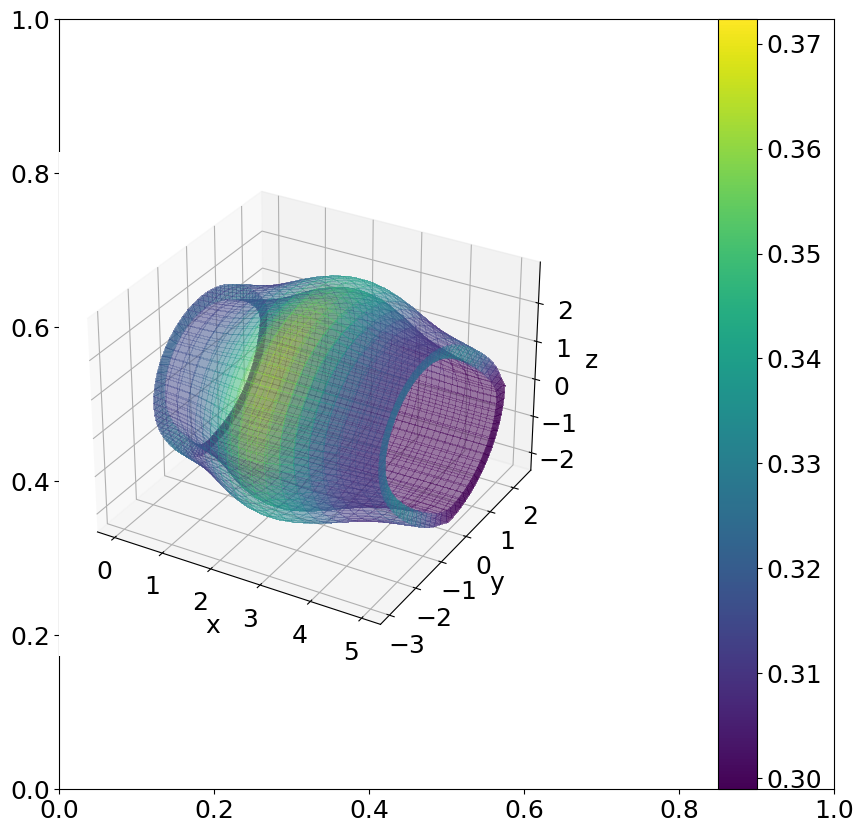

In [43]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []

# without incremental loading
print(" \n \n max. loading: {} \n".format(loading[-1]))

# set Neumann data 
l_val = loading[-1]
neu_data = [(0,'bottom',gN, l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann

count = 0

while True:
    A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    rhs= LS.complete(LS.b)
    r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
    print('Residual =',r)
    print('Energy   =',J(u))
    
    # # solve system # #
    #u_d = make_solver(A).dot(b) 
    u_d = make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d)
    
    w= np.inner(np.transpose(u_d),rhs)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 30:
        break
    
    count+=1
    print(count)
    # update solution
    u += u_d   
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #iter_counts.append(count)
    #---------------------------------------------------#

ud_array.append(u_d) 
print('u= ' , u)
solutions.append(LS.restrict(u))
iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplotC(u, patches_u, kvs_u, MP_u)

In [44]:
sum(iter_counts)

11

 
 
 1. loading: 0.0018886666666666667 

Residual = 0.00779129364788587
Energy   = 0.0
Error= 0.09191081218757445
1
Residual = 30.974843447451637
Energy   = 0.010537545821930984
Error= 0.16318870051091783
2
Residual = 0.031082917482673052
Energy   = -0.0031017480667630245
Error= 0.01272057924213017
3
Residual = 0.01741902865551991
Energy   = -0.003177911908582842
Error= 0.004626915749197944
4
Residual = 4.545896837507965e-05
Energy   = -0.0031906080797442318
Error= 0.0007260392265842171
5
Residual = 1.0379426670027083e-06
Energy   = -0.003190464657891838
Error= 3.1830640842069045e-05
6
Residual = 2.415426499850847e-13
Energy   = -0.003190465529821815
Error= 6.131358681018776e-08
7
Residual = 4.467962433305198e-22
Energy   = -0.0031904654655792648
Error= 6.126801615832386e-13
u=  [0.01384226 0.01369716 0.01817508 ... 0.05949858 0.06156349 0.06305692]
 
 
 2. loading: 0.003777333333333333 

Residual = 0.007791293648244509
Energy   = -0.00988772508356388
Error= 0.08045600545105172
1
Resid

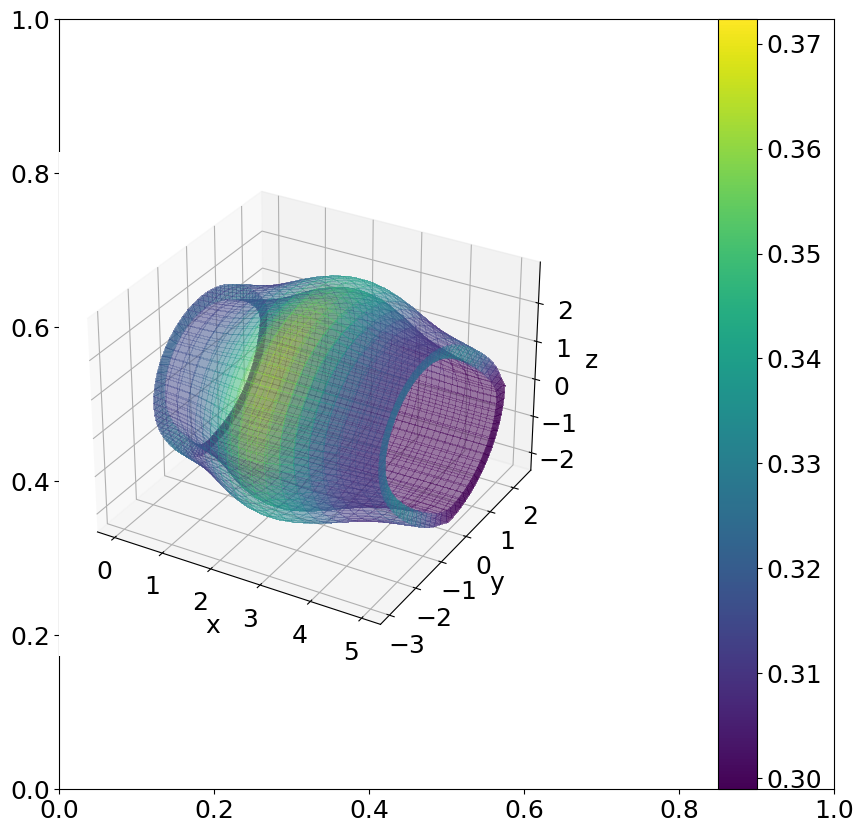

In [45]:
# solve linearized variational problem - iterative with full loading

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN, l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann

    count = 0
    while True:

        A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(Minv.dot(rhs)) #L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
            

        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(LS.A).dot(LS.b)
        u_d = LS.complete(u_d)
             
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        #if r < epsilon * r0: # break condition
        if err < max_err:
            break
        elif count == 20:
            break
            
        # update solution
        u += u_d 
        count+=1
        print(count)
        
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplotC(u, patches_u, kvs_u, MP_u)